# Import backage

In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from exp.sir.train import train
from models_new import Renorm_Dynamic
from exp.sir.dynamic_models_sis_new import Simple_Spring_Model
from ei.EI_calculation import EmergencePsi
from ei.EI_calculation import test_model_causal_multi_sis

from datetime import datetime
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Noise experiments

In [3]:
# nis+ CE macro
mul_batch_size = [0,5000,3000,1000]
sigma_list = [0.00001,0.0001,0.001,0.01,0.1,1]
experiments = len(sigma_list)
rou = -0.5
steps = 7
sz = 4
L = 1
mae2_w = 3
hidden_units = 64
T_total = 30001
dt = 0.01
spring = Simple_Spring_Model(device=device)

In [ ]:
# nis+ micro
scale = 4
eis_micro_e = np.zeros([experiments,T_total//500+1])
losses_micro_e = np.zeros([experiments,T_total//500+1])
MAEs_mstep_micro_e = np.zeros([experiments,T_total//500+1])

for e in range(experiments):
    sigma = sigma_list[e]
    seed = 1 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=0.01) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=0.01)
    
    eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp, net = train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, T2=T_total,framework='nis+')
    eis_micro_e[e,:] = eis_nisp
    losses_micro_e[e,:] = losses_nisp
    #MAEs_mstep_micro_e[e,:] = MAEs_mstep_nisp
    torch.save(net.state_dict(), 'mdl_data/micro noise = '+str(sigma)+'.mdl')

/home/yuanbing/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(
 19%|█▊        | 4999/27000 [22:15<14:18, 25.62it/s]    

In [ ]:
# nis+ macro
sigma_list = [0.00001, 0.0001,0.001,0.01,0.1,1]
experiments = len(sigma_list)
scale = 2
eis_macro_e = np.zeros([experiments,T_total//500+1])
losses_macro_e = np.zeros([experiments,T_total//500+1])
#MAEs_mstep_macro_e = np.zeros([experiments,T_total//500+1])
for e in range(experiments):
    sigma = sigma_list[e]
    seed = 1 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    spring = Simple_Spring_Model(device=device)
    test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=0.01) #sir
    train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=0.01)
    
    eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp, net = train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, T2=T_total,framework='nis+')
    eis_macro_e[e,:] = eis_nisp
    losses_macro_e[e,:] = losses_nisp
    #MAEs_mstep_macro_e[e,:] = MAEs_mstep_nisp
    torch.save(net.state_dict(), 'mdl_data/macro noise = '+str(sigma)+'.mdl')

../../exp/sir/train.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('mdl_data/netwn_init_trnorm0.1+zero_seed=4.mdl').state_dict())
 33%|█

# Plot

In [12]:
sigma_list = [0.00001, 0.0001,0.001,0.01,0.1,1]
ce_list=[]
macro_list=[]
micro_list=[]
psi_list=[]
MAE_raw = torch.nn.L1Loss(reduction='none')
for sigma in sigma_list:
    spring_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) #sir
    s,sp,l,lp = spring_data
    net4 = Renorm_Dynamic(sym_size = sz, latent_size = 4, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)
    net2 = Renorm_Dynamic(sym_size = sz, latent_size = 2, effect_size = sz, 
                         hidden_units = hidden_units, normalized_state=True, device = device)
    net4.to(device=device)
    net2.to(device=device)
    net4.load_state_dict(torch.load('mdl_data/micro noise = '+str(sigma)+'.mdl', weights_only=True))
    net2.load_state_dict(torch.load('mdl_data/macro noise = '+str(sigma)+'.mdl', weights_only=True))
    _, _, V = net2.forward(s)
    psi, _, _ = EmergencePsi(s.cpu().numpy(), V.cpu().detach().numpy()) 
    ei4, sigmas0,weightsnet=test_model_causal_multi_sis(spring_data,MAE_raw,net4,sigma,4, L=L,num_samples = 1000)
    ei2, sigmas0,weightsnet=test_model_causal_multi_sis(spring_data,MAE_raw,net2,sigma,2, L=L,num_samples = 1000)
    ce_list.append(ei2[0]-ei4[0])
    macro_list.append(ei2[0])
    micro_list.append(ei4[0])
    psi_list.append(psi)

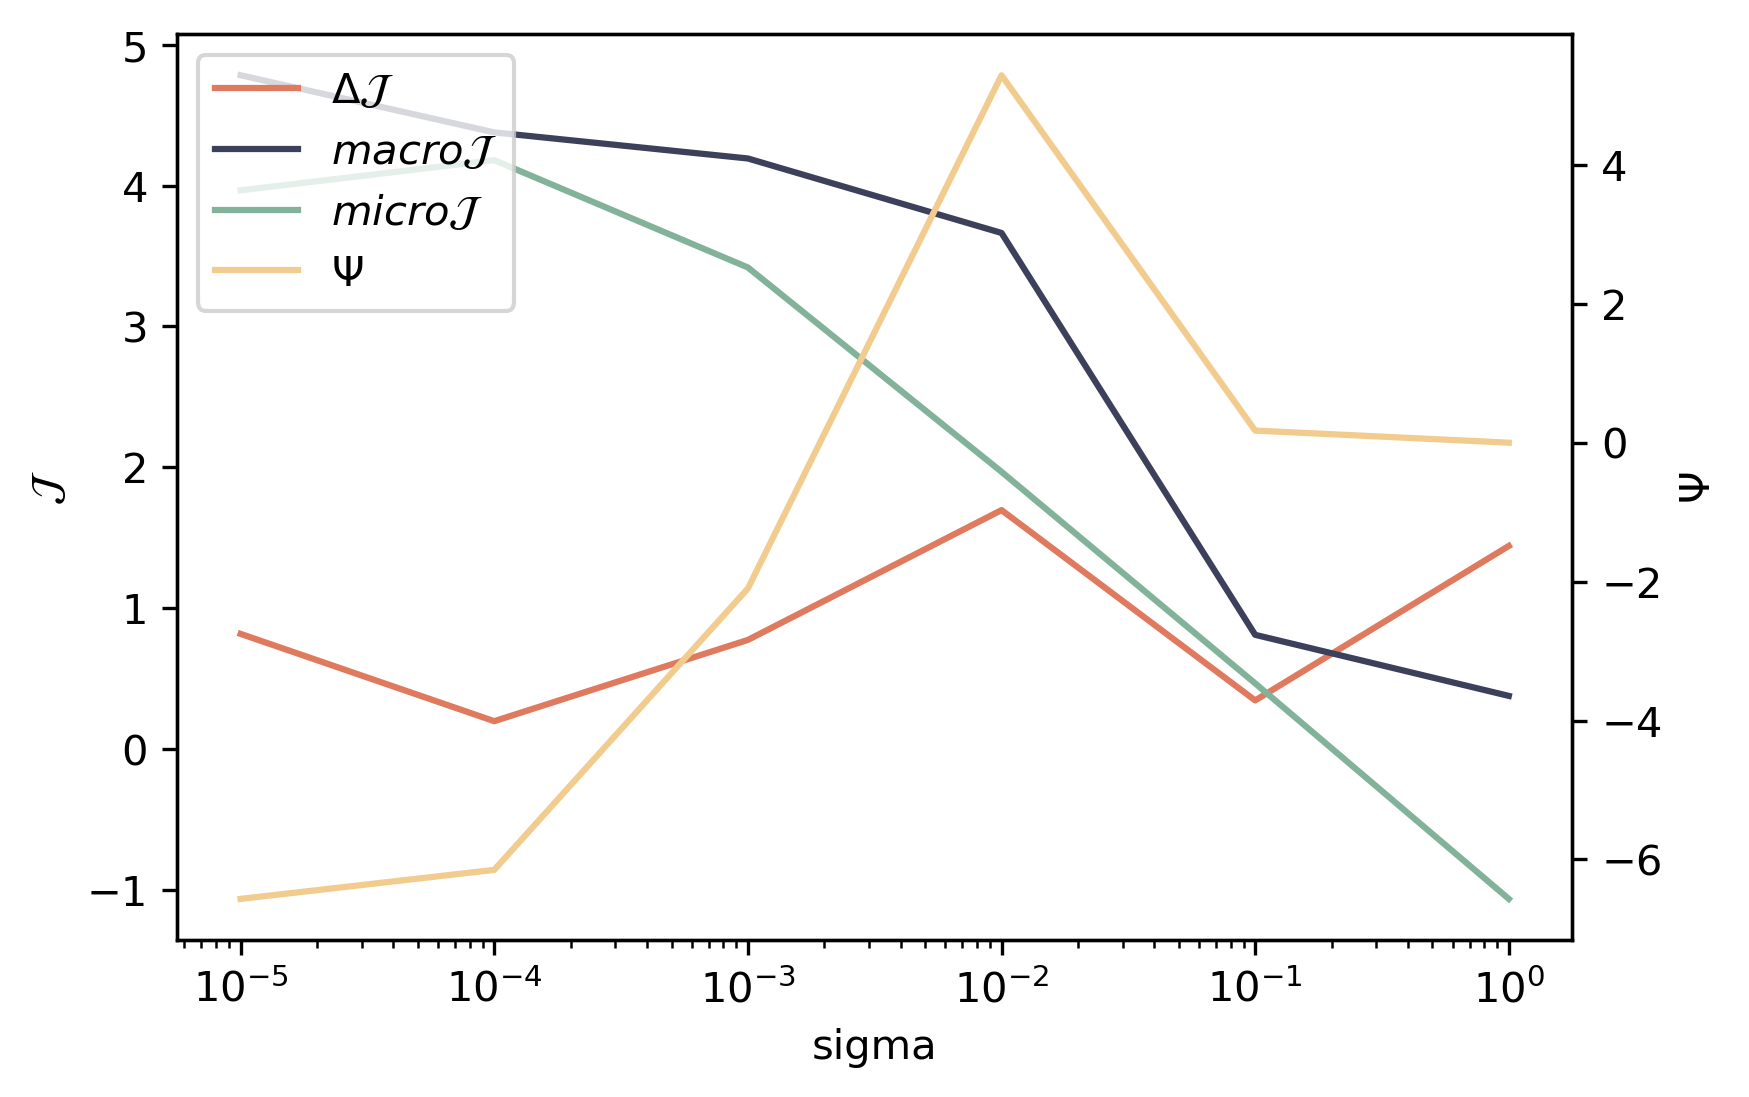

In [13]:
plt.figure(dpi=300)
color_label = ['#F4F1DE', '#DF7A5E', '#3C405B', '#82B29A', '#F2CC8E', '#A8DADC', '#457B9D', '#1D3557']
ax1 = plt.subplot(111)
plt.plot(sigma_list, ce_list,label = r'$\Delta \mathcal{J}$', color=color_label[1])
plt.plot(sigma_list, macro_list,label = r'$macro \mathcal{J}$', color=color_label[2])
plt.plot(sigma_list, micro_list,label = r'$micro \mathcal{J}$', color=color_label[3])
plt.xlabel("sigma")
plt.xscale('log')
plt.ylabel(r'$\mathcal{J}$')

ax2 = ax1.twinx()
plt.plot(sigma_list, psi_list,label = r'$\Psi$', color=color_label[4])
ax2.set_ylabel(r'$\Psi$')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()